In [1]:
import deepchem as dc
import torch
from deepchem.models import GCNModel
import pandas as pd
import numpy as np
import warnings
from tqdm import tqdm
import os
warnings.filterwarnings("ignore")

C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
clean_data = pd.read_csv(r"Data.csv")

In [3]:
data = clean_data

In [4]:
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader

In [5]:
class BBBDataset(Dataset):
    
    def __init__(self,root,transform=None,pre_transform=None,pre_filter=None):
        
        super().__init__(root, transform, pre_transform, pre_filter)
        
        
        
    @property
    def raw_file_names(self):
        
        """
        If this file exists in raw_dir, the download is not triggered
        """
        return "data.csv"
        
    def download(self):
        pass
    
    @property
    def processed_file_names(self):
        return ['data.pt']
    
    
    def process(self):
        
        self.data = pd.read_csv(self.raw_paths[0])
        smiles = self.data.SMILES.to_list()
        labels = self.data.LABELS.to_list()
        
        featurizer = dc.feat.MolGraphConvFeaturizer() ## Feature calculator
        
        X = featurizer.featurize(smiles)
        
        j=0
        for idx, Gdata in tqdm(enumerate(X)):
            
            pyG_data = Gdata
            
            nodes = torch.tensor(pyG_data.node_features,dtype= torch.float32)
            
            Edge_index = torch.tensor(pyG_data.edge_index,dtype= torch.int64 )
            #Edge_feats = torch.tensor(pyG_data.edge_features,dtype=torch.float32)
            y = torch.tensor([labels[idx]],dtype= torch.float32 )
            ### create data object
            data = Data(x=nodes,edge_index=Edge_index,y=y,smiles=smiles[idx])
            torch.save(data,os.path.join(self.processed_dir,f"data_{j}.pt"))
            j+=1
            
    def len (self):
        return self.data.shape[0]
    
    def get(self,idx):
        data = torch.load(os.path.join(self.processed_dir,f'data_{idx}.pt'))
        return data

    
    

In [6]:
dataset = BBBDataset(root=".",)

Processing...
3330it [00:02, 1356.34it/s]
Done!


## Applying PyGCN

In [33]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
from torch_geometric.nn import MessagePassing, GCNConv
from torch_geometric.utils import add_self_loops, degree
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool

class PyGCN(torch.nn.Module):
    
    def __init__(self,):
        
        super().__init__()
              
        self.conv_1 = GCNConv(-1,64,improved=True,) ### First layer convulation
        self.conv_2 = GCNConv(64,32) ### Second layer convulation
        #self.conv_3 = GCNConv(32,16) ### Third layer convulation
        
        ## Two linear layer
        self.fc_1  = Linear(32,16)
        self.fc_2  = Linear(16,1)
       
            
    def forward(self,data,):
        
        batch, x, edge_index, y, smiles  = data.batch, data.x, data.edge_index, data.y, data.smiles
         
        ## Graph convulations
        x = F.relu(self.conv_1(x,edge_index))
        x = F.dropout(x, p=0.4, training=self.training)
        x = F.relu(self.conv_2(x,edge_index))
    
        ## Readout layer
        x = global_mean_pool(x,batch)
        
        ### Final classifier
        x = F.relu(self.fc_1(x))
        x = F.sigmoid(self.fc_2(x))
        
        return x        

In [34]:
config = dict(epochs=100,
             learning_rate=0.01,
             weight_decay=0.00001,
             batch_size = 256,)

In [35]:
from torch.nn import BCEWithLogitsLoss, BCELoss,CrossEntropyLoss, Softmax
from torch.utils.data import random_split
device="cuda"
def Create_model(config):
    
    ### making Data
    train_set, valid_set, test_set = random_split(dataset,[2331,666,333])
    trainloader = DataLoader(train_set,shuffle=True,batch_size=config.get("batch_size"))
    validloader = DataLoader(valid_set, shuffle=True,batch_size=config.get("batch_size"))
    testloader = DataLoader(test_set, shuffle=True,batch_size=config.get("batch_size"))
    
    ## Make the model
    model = PyGCN()
    
    ## Making loss and optimizer
    criterion = BCELoss()
    criterion.cuda()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=config.get("learning_rate"),
                                 weight_decay=config.get("weight_decay"))
    
    ## shifting to GPU
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)## sending model to GPU
    
    return model,criterion,optimizer,trainloader,validloader,testloader  

In [36]:
## train function 

def train(model,optimizer,criterion,loader):
    model.train()
    for data in loader:## Iterate in batches over training dataset
        data.to(device)
        optimizer.zero_grad() ## clear gradients
        out = model(data).squeeze(0) ## single forward pass
        loss = criterion(out,data.y.unsqueeze(1)) ## compute the loss
        loss.backward() ## Derive gradients
        optimizer.step()## update parameters based on gradients
        

In [37]:
@torch.no_grad()
def test(model,criterion,loader):
    model.eval() ## initiating evaluation mode
    
    y_true = []
    proab =  []
    val_loss = []
    
    for data in loader:## Iterate in batches over training dataset
        data.to(device)
        out = model(data).squeeze(0) ## single forward pass
        
        proab.extend(out.detach().cpu().numpy().squeeze().tolist()) ## appending to list each batch
        y_true.extend(data.y.unsqueeze(1).squeeze().tolist()) ## appending true value of each batch
    
        loss = criterion(out,data.y.unsqueeze(1))
        val_loss.append(loss)
        
    av_loss = torch.sum(torch.tensor(val_loss))/len(loader)
    accuracy = accuracy_counter(proab,y_true)
    
    return (av_loss,accuracy)

In [38]:
from sklearn.metrics import accuracy_score
def accuracy_counter(y_prob,y_true):
    
    y_prob = np.array(y_prob)
    y_prob = np.where(y_prob <= 0.5, 0, y_prob)
    y_prob = np.where(y_prob > 0.5, 1, y_prob)
    accuracy = accuracy_score(np.array(y_true),y_prob)
    return (accuracy,)

In [39]:
model,criterion,optimizer,trainloader,validloader,testloader = Create_model(config)

## Accuracies
traine_accuracy = []
vale_accuracy   = []
teste_accuracy  = []

## Losses
epoch_loss =      []
valida_loss =     []
test_loss_full =  []

for epoch in range(1,config.get("epochs")):
    
    ### training the model
    train(model,optimizer,criterion,trainloader)
    
    ## testing on train set
    train_loss,train_accuracy = test(model,criterion,trainloader)
    
    val_loss,val_accuracy = test(model,criterion,validloader)
    
    test_loss,test_accuracy = test(model,criterion,testloader)
    
    ##losses
    epoch_loss.append(train_loss)
    valida_loss.append(val_loss)
    test_loss_full.append(test_loss)
    
    ## accuracy
    traine_accuracy.append(train_accuracy[0])
    vale_accuracy.append(val_accuracy[0])
    teste_accuracy.append(test_accuracy[0])
    
    print(f'Epoch: {epoch:03d}, Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy[0]:.4f}, val loss: {val_loss:.4f}, val accuracy: {val_accuracy[0]:.4f}')

Epoch: 001, Train loss: 0.6623, Train accuracy: 0.6036, val loss: 0.6633, val accuracy: 0.6036
Epoch: 002, Train loss: 0.6642, Train accuracy: 0.6032, val loss: 0.6607, val accuracy: 0.6036
Epoch: 003, Train loss: 0.6422, Train accuracy: 0.6075, val loss: 0.6479, val accuracy: 0.6006
Epoch: 004, Train loss: 0.6454, Train accuracy: 0.6135, val loss: 0.6434, val accuracy: 0.6096
Epoch: 005, Train loss: 0.6273, Train accuracy: 0.6486, val loss: 0.6296, val accuracy: 0.6577
Epoch: 006, Train loss: 0.6129, Train accuracy: 0.6834, val loss: 0.6126, val accuracy: 0.7012
Epoch: 007, Train loss: 0.6131, Train accuracy: 0.6907, val loss: 0.6147, val accuracy: 0.7027
Epoch: 008, Train loss: 0.6206, Train accuracy: 0.6637, val loss: 0.6323, val accuracy: 0.6592
Epoch: 009, Train loss: 0.6067, Train accuracy: 0.6894, val loss: 0.5953, val accuracy: 0.6862


KeyboardInterrupt: 

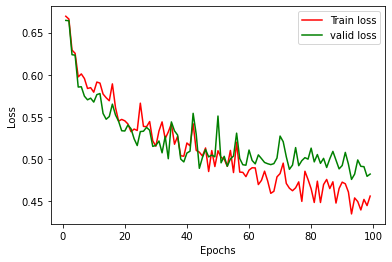

In [32]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(1,config.get("epochs"))],[i.cpu().detach().numpy() for i  in epoch_loss],label="Train loss",color="Red",)
plt.plot([i for i in range(1,config.get("epochs"))],[i.cpu().detach().numpy() for i in valida_loss],label="valid loss",color="Green")
#plt.plot([i for i in range(1,config.get("epochs"))],[i.cpu().detach().numpy() for i in test_loss],label="Test loss",color="Blue")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()



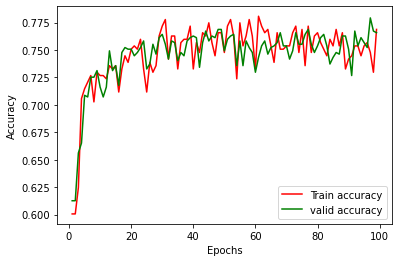

In [31]:
plt.plot([i for i in range(1,config.get("epochs"))],[i for i  in teste_accuracy],label="Train accuracy",color="Red",)
plt.plot([i for i in range(1,config.get("epochs"))],[i  for i in vale_accuracy],label="valid accuracy",color="Green")
#plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i in test_loss],label="Test loss",color="Blue")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


### Saving Model

In [30]:
torch.save(net,"model-GCN")

In [31]:
model1 = torch.load("model-GCN")

In [32]:
model1.eval()
model1.to("cpu")
model1([*testloader][4])

IndexError: list index out of range

#### Implementing Weight and bias